In [1]:
# Libraries
using AlgebraicDynamics
using AlgebraicDynamics.DWDDynam
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz
using Plots
using Plots.PlotMeasures
using DifferentialEquations

In [2]:
show_diagram(d::WiringDiagram) = to_graphviz(d, orientation=LeftToRight);

### Inputs to algorithm 

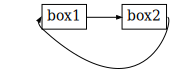

In [3]:
# Closed diagram
diagram = WiringDiagram( [:1], [] ); 

# Boxes
box1 = add_box!( diagram, Box(:box1, [:1], [:1]) );
box2 = add_box!( diagram, Box(:box2, [:1], [:1]) );

# Connections
add_wires!(diagram, [
    (box2,1) => (box1,1)
    (box1,1) => (box2,1)
])

show_diagram(diagram)

In [14]:
#- Coefficients
# Mass #1
k1 = 1;     
c1 = 2;

# Mass #2
k2 = 1; 
c2 = 4;

# Parameters for ODE Solver:
x_init = [1];                # External input: Taken as the ID of a box. How to store external state?
u_init = [1, 0, 0];          # Initial conditions
t_span = (0, 20);            # Interval of solution

In [5]:
#- Dynamic equations:
dynamic_1(u, x, p, t) = [ u[2], -k1*(u[1] - x[1]) - c1*u[2] ];     # Two states, 1 input
dynamic_2(u, x, p, t) = [ -k2*(u[1] - x[1]) ];                     # One state, 1 input

# Array of dynamics functions 
dynamics = [dynamic_1, dynamic_2];                    # Note: Define Data structure that provides number of states? 

### Algorithm to assign semantics 

In [6]:
#- Find the output length of a function:    Note: Cleaner alternative? length(Base.return_types(dynamic_2))

function output_size(func)
    n_out = 10;  # Initial guess element count
    
    # Evaluate function until it successfully executes
    while true
        # Test array (contents do not matter)
        array = Array{Float64,1}(undef, n_out);
        try 
            # Find the number of elemets output
            n_out = length( func(array, array, array, NaN) );
            break;
        catch (error)
            # Increase the array size if unsuccessful
            n_out *= 10; 
        end
    end
    return n_out;
end

output_size (generic function with 1 method)

In [7]:
#- Determine Box parameters: 

# Number of boxes
count = nboxes(diagram);   

# Initialize arrays
n_input = Array{Int64,1}(undef, count);
n_output = Array{Int64,1}(undef, count);
n_state = Array{Int64,1}(undef, count);

# Store parameters of each box
for i = 1:count
    n_input[i] = length(in_wires(diagram, i));
    n_output[i] = length(out_wires(diagram, i));
    n_state[i] = output_size(dynamics[i])
end

In [9]:
#- Global state vectors:
state = Array{Array{Float64,1}}(undef, count);

# Fill array with empty state vectors
for i = 1:count
    setindex!( state, zeros(n_state[i]), i );
end

In [10]:
#- Generate readout functions:
readout = Array{Function}(undef, count);    # Initialize

# Make a readout function for each box
for i = 1:count
    
    function update_state(u)
        # Update the state
        global state[i] = u;
        # Output the ID of the current box
        return repeat( [Float64(i)], inner = n_output[i] );
    end 
    
    # Store the function
    setindex!( readout, update_state, i );
end

In [11]:
#- Generate Input Functions: 
dyn_function = Array{Function}(undef, count);

# Make a dynamics function for each box
for i = 1:count
    
    function set_input(u, x, p, t)
        # Store input box IDs  
        box_id = x;        
                 
        # Iterate across all input boxes
        x = []        
        for k = 1:length(box_id)  
            # Find current box id
            id = Int( box_id[k] );
            # Concatenate state vector of box
            x = [ x; state[id] ]
        end
        
        # Output given function with modified input
        return dynamics[i](u, x, p, t);
    end
    # Store the functions
    setindex!( dyn_function, set_input, i );
end

In [12]:
#- Construct Continuous Machines:
machine = Array{ContinuousMachine{Float64}}(undef, count);

# Create a machine for each box
for i = 1:count
    machine[i] = ContinuousMachine{Float64}( n_input[i], n_state[i], n_output[i], dyn_function[i], readout[i] );
end
 
# Compose machines with diagram
net_machine = oapply(diagram, machine);

### Display output 

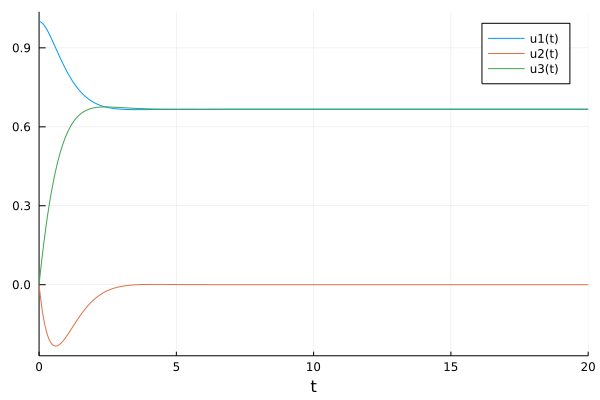

In [15]:
#- Solve system:

# Convert into ODE form:
data = ODEProblem(net_machine, u_init, x_init, t_span);

# Solve and plot system
sol = solve( data, alg_hints=[:stiff] );
plot(sol)

__Concluding remarks__: This scheme appears to work for closed systems without external inputs. However once an external input is present the scheme breaks down as there is no box associated with this information. An exception needs to be made that uses the raw input values rather than referencing the state of a box. This required _identifying_ an external input. How can this be done?